In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, AveragePooling1D, Dropout
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, MaxPooling1D, BatchNormalization, Softmax
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# Building Probabilistic Deep Learning Models
- dealing with uncertainty involved in modeling process
- want models to assign higher levels of uncertainty to incorrect predictions
- two main sources of uncertainty: aleatoric and epistemic
  - aleatoric: uncertainty in the data itself (e.g. predicting coin toss; can't do it with certainty but can predict the probability)
  - epistemic: model uncertainty (if there is not enough data, deep learning models may not have the correct parameters)

## Maximum Likelihood estimation
Probability density (or mass, for discrete distributions) function:

$$
P(y | \theta) = \text{Prob} (\text{sampling value $y$ from a distribution with parameter $\theta$})
$$ 

Multiple samples:

$$
P(y_1, \ldots, y_n | \theta) = \prod_{i=1}^n P(y_i | \theta)
$$

These functions are used for **probability**, where you know the distribution and want to make deductions about possible values sampled from it.

The **likelihood** is the reverse where the samples are fixed and $\theta$ is considered the independent variable.  In this case, you know the samples from data collected but don't know $\theta$.

$$
L(\theta | y_1, \ldots, y_n) = P(y_1, \ldots, y_n | \theta)
$$

## Example: Bernoulli Distribution

$$
\begin{align}
L(\theta | y) &= \begin{cases}
1 - \theta \quad \text{if} \, y = 0 \\
\theta \qquad \, \, \, \text{if} \, y = 1 \\
\end{cases} \\
&= (1 - \theta)^{1 - y} \theta^y \quad y \in \{0,1\}
\end{align}
$$

Assuming samples are independent:

$$
L(\theta | y_1, \ldots, y_n) = \prod_{i=1}^n (1 - \theta)^{1 -y} \theta^y
$$

## Example: Normal Distribution

$$
L(\mu, \sigma | y) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Big( - \frac{1}{2 \sigma^2} (y - \mu)^2 \Big)
$$

Assuming samples are independent:

$$
L(\theta | y_1, \ldots, y_n) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Big( - \frac{1}{2 \sigma^2} (y_i - \mu)^2 \Big)
$$

The likelihood is the same as the probability density function except it is a function of $\mu$ and $\sigma$ and the samples are considered constant.

## Maxium Likelihood Extimation

Usually we want to find maximum likelihood estimate $\theta_{MLE}$ which is the value of $\theta$ that maximizes $L(\theta | y_1, \ldots, y_n)$.

## Negative log-likelihood

The likelihood is a product (assuming independent observations) which can be turned into a sum by taking the log of the product.  Since the log function increases with its argument, maximizing the log-likelihood is equivalent to maximizing the likelihood.  Since the loss function must be a minimization problem, we consider the negative log-likelihood:

$$
\theta_{MLE} = \arg \min_{\theta} - \sum_{i=1}^n \log L(y_i | \theta)
$$

This is often used to find the best weights in a neural network where we assume that neural network predictions form part of a distribution that the true label is drawn from.  In the case of binary classifiers, sparse categorical crossentropy is used as the loss function and, in fact, it is exactly the negative log likelihood of a Bernoulli distribution.  In regression, minimizing the sum of squared errors is equivalent to minimizing the negative log-likelihood of a gaussian distribution (assuming Gaussian error term with constant variance).



## DistributionLambda Layer

In [3]:
model = Sequential([
                    Dense(1, input_shape=(2,)),
                    tfpl.DistributionLambda(
                        lambda t: tfd.Normal(loc=t, scale=1), # output of previous layer describes mean of this normal distribution
                        convert_to_tensor_fn=tfd.Distribution.sample) # if you want to use output downstream of model, it
                                                                      # needs to be converted from distribution object into a tensor,
                                                                      # which can be done by sampling from distribution
])                                                                    # (could also be done with mean or mode)
# one required argument for Distribution lambda is a function that takes previous layer's output as input and returns distribution object
# this explicitly captures the uncertainty in the model by converting the output in the dense layer to a distribution

# output is now a distribution object instead of a scaler
# e.g. X_train --> shape (16,2) --> model(X_train) --> Normal dist with batch_shape (16,1) and event shape ()
# batch_shape (16,1) for number of samples (16) and number of outputs from previous dense layer (1)

def nll(y_true, y_pred):
  return - y_pred.log_prob(y_true) # remember that y_pred is now a distribution object

model.compile(loss=nll, optimizer='rmsprop')
# model.fit(X_train, y_train, epochs=10)

# model(X_test).sample() # get predictions by sampling from distribution
# model(X_test).mean()

Create a probabilistic model using the `DistributionLambda` layer whose first layer represents:
$$
y = sigmoid(x) = \frac{1}{1 + \exp (-x)}
$$

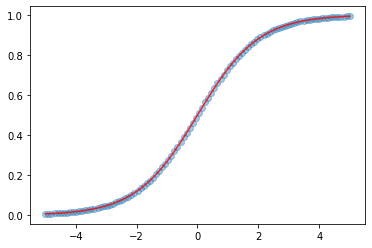

In [4]:
# deterministic model
model = Sequential([
                    Dense(1, input_shape=(1,), activation='sigmoid',
                          kernel_initializer=tf.constant_initializer(1),
                          bias_initializer=tf.constant_initializer(0))
])
x = np.linspace(-5,5,100)
plt.scatter(x, model.predict(x), alpha=0.4)
plt.plot(x, 1/(1+np.exp(-x)), color='r', alpha=0.8)
plt.show()

In [5]:
# deterministic model always returns same prediction for same x value
x = [0]
for _ in range(5):
  print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


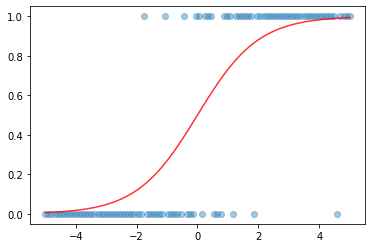

In [6]:
# probabilistic model
model = Sequential([
                    Dense(1, input_shape=(1,), activation='sigmoid',
                          kernel_initializer=tf.constant_initializer(1),
                          bias_initializer=tf.constant_initializer(0)),
                    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                                            convert_to_tensor_fn=tfd.Distribution.sample)
])
x = np.linspace(-5,5,100)
plt.scatter(x, model.predict(x), alpha=0.4)
plt.plot(x, 1/(1+np.exp(-x)), color='r', alpha=0.8)
plt.show()

In [7]:
x = [0]
for _ in range(5):
  print(model.predict(x))

[[1]]
[[1]]
[[0]]
[[0]]
[[0]]


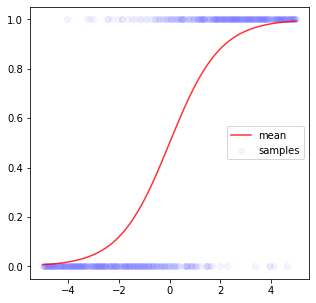

In [8]:
X_train = np.linspace(-5,5,500)[:, np.newaxis]
y_train = model.predict(X_train)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_train, y_train, alpha=0.04, color='b', label='samples')
ax.plot(X_train, model(X_train).mean().numpy().flatten(), color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

In [9]:
# change initial weights/biases so we can train model
model_untrained = Sequential([
                    Dense(1, input_shape=(1,), activation='sigmoid',
                          kernel_initializer=tf.constant_initializer(2),
                          bias_initializer=tf.constant_initializer(2)),
                    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                                            convert_to_tensor_fn=tfd.Distribution.sample)
])
def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model_untrained.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.01))

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0,0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
  model_untrained.fit(X_train, y_train, epochs=1, verbose=False)
  epochs.append(epoch)
  training_weights.append(model_untrained.weights[0].numpy()[0,0])
  training_bias.append(model_untrained.weights[1].numpy()[0])

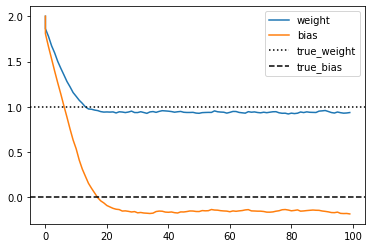

In [10]:
plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(1, label='true_weight', color='k', linestyle=':')
plt.axhline(0, label='true_bias', color='k', linestyle='--')
plt.legend()
plt.show()

## Probabilistic Layers

In [11]:
model = Sequential([
                    Dense(16, activation='relu', input_shape=(2,)),
                    Dense(2), # (batch_shape, 2)
                    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1],
                                                                                 scale=tf.math.softplus(t[...,1:]))))
                    # softplus is needed to make sure scale is positive
                    # ... is needed to account for batch_shapes of any rank
])
# alternatively:
model = Sequential([
                    Dense(16, activation='relu', input_shape=(2,)),
                    Dense(2), 
                    tfpl.IndependentNormal(event_shape=(1)) # accomplishes exact same thing as above
                    # event shape of 1 means this layer requires two parameters to be defined: mean and std dev
                    # this is why the previous dense layer has two units
                    # it also passes std devs through softplus function to make sure they are positive
])
model = Sequential([
                    Dense(16, activation='relu', input_shape=(2,)),
                    Dense(4), # requires 4 now
                    tfpl.IndependentNormal(event_shape=(2)) # this is specifying 2D multivariate normal distribution so now need 4 inputs
                    # two means and two std devs of a covariance matrix diagonal
])
model = Sequential([
                    Dense(16, activation='relu', input_shape=(2,)),
                    Dense(8), # requires 8 now
                    tfpl.IndependentNormal(event_shape=([2,2]))
])
# potentially tricky to know exactly how many params are needed for a certain event shape
# use params_size method in previous dense layer to have it figure out for you
event_shape = 2
model = Sequential([
                    Dense(16, activation='relu', input_shape=(2,)),
                    Dense(tfpl.IndependentNormal.params_size(event_shape)),
                    tfpl.IndependentNormal(event_shape,
                                           convert_to_tensor_fn=tfd.Distribution.sample)
])
# for multi class classification problems, you can use OneHotCategorical layer instead of Dense layer with softmax at the end
num_classes = 10
model = Sequential([
                    Conv2D(16, 3, activation='relu', input_shape=(32,32,3)),
                    MaxPooling2D(3),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
                    tfpl.OneHotCategorical(num_classes) # replaces Dense(num_classes, activation='softmax')
])
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true)) # y_true is one hot vector --> this returns nll of correct class

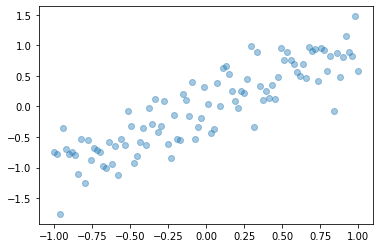

In [12]:
# create training data
X_train = np.linspace(-1,1,100)[:,np.newaxis]
y_train = X_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(X_train, y_train, alpha=0.4)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


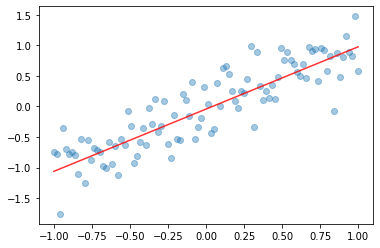

In [13]:
# deterministic linear regression with MSE loss
model = Sequential([
                    Dense(1, input_shape=(1,))
])
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(0.005))
model.summary()
model.fit(X_train, y_train, epochs=200, verbose=False)

plt.scatter(X_train, y_train, alpha=0.4)
plt.plot(X_train, model.predict(X_train), color='red', alpha=0.8)
plt.show()

Disadvantage is that a deterministic model doesn't capture the uncertainty in predictions

In [14]:
# deterministic linear regression with MSE loss
model = Sequential([
                    Dense(1, input_shape=(1,)),
                    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1))) # parameterize mean of normal dist.
])
model.summary()
# same number of trainable params but output is now a distribution object

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_4 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.005))
model.fit(X_train, y_train, epochs=200, verbose=False)

In [16]:
x = np.array([[0]])
y_model = model(x)
y_model

<tfp.distributions.Independent 'sequential_11_distribution_lambda_4_Independentsequential_11_distribution_lambda_4_Normal' batch_shape=[1] event_shape=[1] dtype=float32>

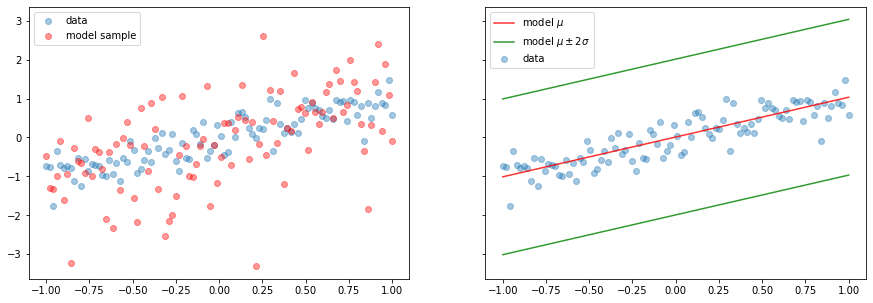

In [17]:
y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

Now let's learn mean *AND* standard deviation!

In [18]:
event_shape = 1
model = Sequential([
                    Dense(tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)), # needs two units now or just use params_size
                    tfpl.IndependentNormal(event_shape) # instead of just mean, this parameterizes mean and std dev
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2)                 4         
_________________________________________________________________
independent_normal_4 (Indepe multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.005))
model.fit(X_train, y_train, epochs=200, verbose=False)

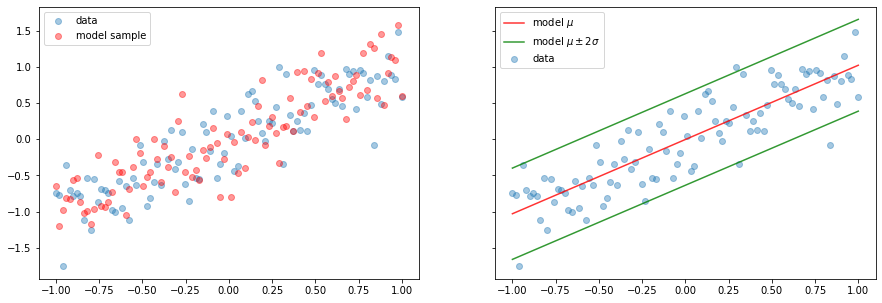

In [20]:
y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

Much better fit! Now we have information on mean and uncertainty in a model prediction (compared to just mean for deterministic model)

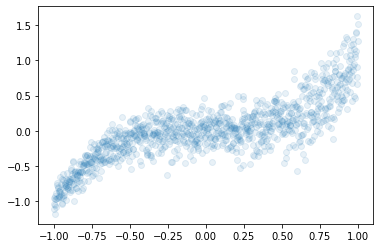

In [21]:
# let's also look at nonlinear models
X_train = np.linspace(-1,1,1000)[:, np.newaxis]
# not only nonlinear trend but the error is also a function of x so it isnt same for all x unlike previous example
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]
plt.scatter(X_train, y_train, alpha=0.1)

In [22]:
event_shape = 1
model = Sequential([
                    Dense(8, input_shape=(1,), activation='sigmoid'),
                    Dense(tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)), # needs two units now or just use params_size
                    tfpl.IndependentNormal(event_shape) # instead of just mean, this parameterizes mean and std dev
])
model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.005))
model.summary()
model.fit(X_train, y_train, epochs=200, verbose=False)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_5 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


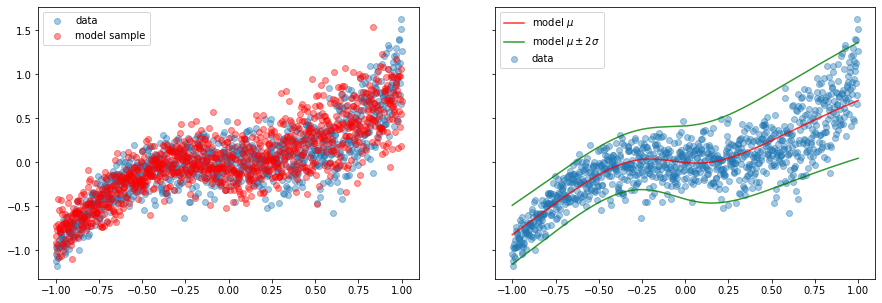

In [23]:
y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

## Bayes by Backprop
Instead of the weights of each neuron being a single value, you can describe them with distributions. Bayes by Backprop is a method to determine the parameters of the distributions.  Mathematically complex, need to explore further.

## DenseVariational layer

In [24]:
# need to define the prior distribution P(w) - our belief for the distribution of params, w, before seeing any data
# standard assumption is the prior is a spherical gaussian, i.e. an independent normal dist. for each weight and bias
def prior(kernel_size, bias_size, dtype=None): # prior distribution for a dense layer
  n = kernel_size + bias_size
  return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1), reinterpreted_batch_ndims=1)
  # t is the input to the dense layer that this prior dist describes
  # note that t isnt in the lambda function so the dist is the same for any input
  # the prior does not have any trainable variables so it won't change during optimization

# need to define posterior distribution 
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return Sequential([
                     tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype), # VariableLayer --> returns a tf variable
                     tfpl.IndependentNormal(n) # convert_to_tensor_fn is sampling by default (how to get weights for forward pass)
  ])
  # similar to the prior function, this returns a callable object that returns a distribution object but it is a model rather than layer

# rules for defining prior/posterior:
  # 1) inputs are kernel_size, bias_size, dtype
  # 2) they return callable objects that take in tensor as input and return distribution object

N = len(X_train)
model = Sequential([
                    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N, activation='relu', input_shape=(8,)),
                    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N), 
                    tfpl.IndependentNormal(1)
])
# replace dense layers with DenseVariational layers where everything is the same except the addition of posterior/prior functions
# this layer automatically applies KL_divergence loss which can be weighted according to kl_weight param (1/N is a the best choice)
# objective is to maximize ELBO (evidence lower bound) which is the difference between two terms
  # 1) sum of expected log likelihood over the data (postive of nll loss function I have been using)
  # 2) KL divergence between posterior and prior 
           # KL divergence measures similarity btw two functions so it will force the posterior to be similar to prior to minimize the loss
           # kind of like regularizing the posterior
# note that maximizing the ELBO requires a trade-off
# i.e. we want the posterior to maximize log likelihood but at the same time we don't want it to diverge too much from prior

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true)) # nll is estimated using a single sample of posteriors to get weights
# the KL_divergence term is automatically included in the DenseVariational layers

Note that the posterior is a "variational posterior" to approximate the true posterior because it is generally to difficult to calculate the true posterior using Bayes' Theorem. We tune the parameters of the variational posterior to get as close to the true posterior as possible.

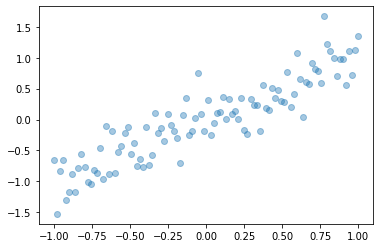

In [25]:
# same data as before with new model that accounts for uncertainty in weights
X_train = np.linspace(-1,1,100)[:,np.newaxis]
y_train = X_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(X_train, y_train, alpha=0.4)

In [26]:
def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = Sequential([
                            tfpl.DistributionLambda(
                                lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
                            ) # prior is just unit gaussian for all parameters of a DenseVariational layer
  ]) # no trainable variables since the zeros and ones are hardcoded in
     # also doesn't use the input so we don't even need to use Sequential but might be convenient since posterior does need it
  return prior_model

# need to assume a distribution for posterior --> let's assume multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  # we want trainable parameters, which we get using VariableLayer which are then passed to next layer
  posterior_model = Sequential([
                             tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype), 
                             tfpl.MultivariateNormalTriL(n)
  ])
  return posterior_model

In [27]:
model = Sequential([
                    tfpl.DenseVariational(1, posterior, prior, input_shape=(1,), kl_weight=1/len(X_train), kl_use_exact=True)
])
# can use deterministic loss since the output of this model is not a distribution object
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(0.005))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


A deterministic linear regression has two trainable params (mean and intercept) but this has 5.  This is the mean and variance of mean and intercept (4) as well as the covariance between them.  Note that the MultivariateNormalTriL scale param is a lower triangular matrix which will have 3 non-zero params for a 2x2 matrix since the upper right corner is 0.  These three params are the variance and covariance described in the second sentence

In [28]:
model.fit(X_train, y_train, epochs=500, verbose=False)

In [29]:
dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean: ', model_prior.mean().numpy()) # did not change during training since it is not trainable
print('prior variance: ', model_prior.variance().numpy()) # did not change during training since it is not trainable
print('posterior mean: ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy())

prior mean:  [0. 0.]
prior variance:  [1. 1.]
posterior mean:  [ 1.0255601  -0.01181691]
posterior covariance:  [[ 0.01487845 -0.00026619]
 [-0.00026619  0.00594118]]


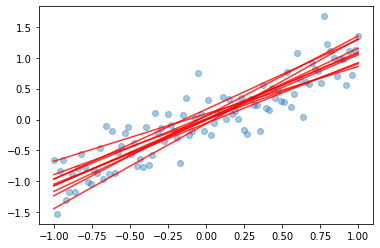

In [30]:
# plot an ensemble of linear regressions with weights sample from posterior distribution
plt.scatter(X_train, y_train, alpha=0.4)
for _ in range(10):
  y_model = model(X_train) # each time I call model on training data, a different sample is taken from posterior
  plt.plot(X_train, y_model, color='red', alpha=0.8)
plt.show()

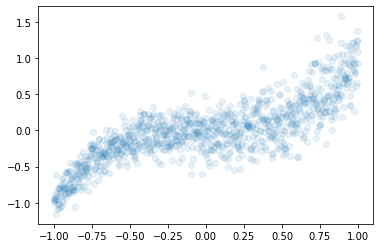

In [31]:
# let's also look at nonlinear models
X_train = np.linspace(-1,1,1000)[:, np.newaxis]
# not only nonlinear trend but the error is also a function of x so it isnt same for all x unlike previous example
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]
plt.scatter(X_train, y_train, alpha=0.1)

In [32]:
# this model accounts for uncertainty in weights and also returns a distribution object
# allows us to model both epistemic and aleatoric uncertainty, respectively
model = Sequential([
                    tfpl.DenseVariational(8, posterior, prior, kl_weight=1/len(X_train), input_shape=(1,), activation='sigmoid'),
                    tfpl.DenseVariational(tfpl.IndependentNormal.params_size(1), posterior, prior, kl_weight=1/len(X_train)),
                    tfpl.IndependentNormal(1)
])
def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.005))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_3 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_4 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_7 (Indepe multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train, y_train, epochs=1000, verbose=False)

In [34]:
model.evaluate(X_train, y_train)

32/32 [==============================] - 1s 1ms/step - loss: 0.0142


0.01424924936145544

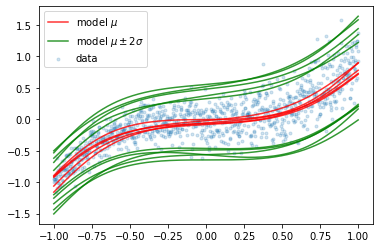

In [35]:
plt.scatter(X_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
  y_model = model(X_train)
  y_hat = y_model.mean()
  y_hat_m2sd = y_hat - 2 * y_model.stddev()
  y_hat_p2sd = y_hat + 2 * y_model.stddev()
  if _ == 0:
    plt.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
    plt.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
    plt.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)
  else:
    plt.plot(X_train, y_hat, color='red', alpha=0.8)
    plt.plot(X_train, y_hat_m2sd, color='green', alpha=0.8)
    plt.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)
plt.legend()
plt.show()

This allows us to model the uncertainty in the prediction by learning the variation as well as model the uncertainty in the parameters themselves, i.e. both aleatoric and epistemic uncertainty, respectively

## Reparameterization layers
Dense Variational layer is updated version of dense reparameterization layer - need to check if there is an updated version for convolutional layers (there wasn't when the video was filmed)

In [36]:
# reparamaterization layers have same underlying algorithms and theoretical background as dense variational layer
model = Sequential([
                    tfpl.Convolution2DReparameterization(16, 3, activation='relu', input_shape=(28,28,1),
                                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
                                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn), # replaces Conv2D
                    MaxPooling2D(3),
                    Flatten(),
                    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)), # older version of Dense Variational layer
                    tfpl.OneHotCategorical(10)
])
# tfpl.default_mean_field_normal_fn() returns independent normal dist with trainable mean/stddev
# can also define a function to make a posterior/prior
def custom_multivariate_normal_fn(dtype, shape, name, trainable, add_variable_fn): # these are required inputs
  normal = tfd.Normal(loc=tf.zeros(shape, dtype), scale=2*tf.ones(shape, dtype))
  batch_ndims = tf.size(normal.batch_shape_tensor())
  return tfd.Independent(normal, reinterpreted_batch_ndims=batch_ndims) # must return distribution object

model = Sequential([
                    tfpl.Convolution2DReparameterization(16, 3, activation='relu', input_shape=(28,28,1),
                                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
                                                         kernel_prior_fn=custom_multivariate_normal_fn), # replaces Conv2D
                    MaxPooling2D(3),
                    Flatten(),
                    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)), # older version of Dense Variational layer
                    tfpl.OneHotCategorical(10)
])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [37]:
# load HAR dataset (smartphone accelerometer data while person walks)
def load_HAR_data():
  X_train = np.load('gdrive/MyDrive/Colab Notebooks/Datasets/HAR/x_train.npy')[...,:6]
  y_train = np.load('gdrive/MyDrive/Colab Notebooks/Datasets/HAR/y_train.npy') - 1
  X_test = np.load('gdrive/MyDrive/Colab Notebooks/Datasets/HAR/x_test.npy')[...,:6]
  y_test = np.load('gdrive/MyDrive/Colab Notebooks/Datasets/HAR/y_test.npy') - 1
  return (X_train, y_train), (X_test, y_test)

label_to_activity = {0:'walking horizontally', 1:'walking upstairs', 2:'walking downstairs',
                     3:'sitting', 4:'standing', 5:'laying'}

# change label to one-hot encoding

def integer_to_onehot(data_integer):
  data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
  for row in range(data_integer.shape[0]):
    integer = int(data_integer[row])
    data_onehot[row, integer] = 1
  return data_onehot

(X_train, y_train), (X_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

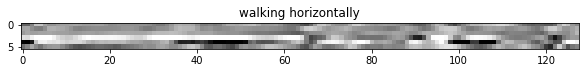

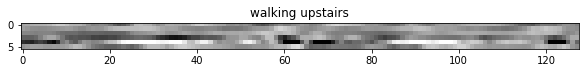

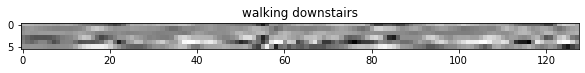

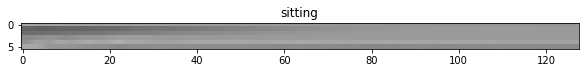

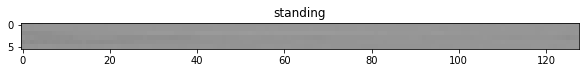

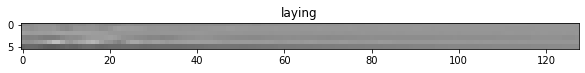

In [38]:
# plot data
def make_plots(num_examples_per_category):
  for label in range(6):
    X_label = X_train[y_train[:,0] == label]
    for i in range(num_examples_per_category):
      fig, ax = plt.subplots(figsize=(10,1))
      ax.imshow(X_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
      if i == 0:
        ax.set_title(label_to_activity[label])
      plt.show()

make_plots(1)

In [39]:
# standard deterministic model:
model = Sequential([
                    Conv1D(input_shape=(128,6), filters=8, kernel_size=16, activation='relu'),
                    MaxPooling1D(16),
                    Flatten(),
                    Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


In [45]:
# convert to probabilistic model

divergence_fn = lambda q, p, _: tfd.kl_divergence(q,p) / len(X_train) # only works if analytical solution is known by tensorflow

model = Sequential([
    tfpl.Convolution1DReparameterization(
        input_shape=(128,6), filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    MaxPooling1D(16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    tfpl.OneHotCategorical(event_size=6)
])
model.summary() # twice as many trainable params since each param is replaced with mean/stddev

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_3  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_4 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_5 (OneHo multiple                  0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [46]:
def kl_approx(q, p, q_tensor): # Monte Carlo approximation of KL divergence
  return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor: k1_approx(q, p, q_tensor) / len(X_train) # need to approximate k1_div if analytical solution unknown

In [47]:
def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(0.005), metrics='accuracy', experimental_run_tf_function=False)
# need experimental_run_tf_function=False when using reparameterization layers

In [48]:
model.fit(X_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(X_train, y_train_oh)
model.evaluate(X_test, y_test_oh)

93/93 [==============================] - 0s 3ms/step - loss: 0.9826 - accuracy: 0.6607


[0.9825744032859802, 0.6606718897819519]

In [49]:
def analyze_model_predictions(image_num):
  # show accelerometer data
  print('Accelerometer data:')
  fig, ax = plt.subplots(figsize=(10,1))
  ax.imshow(X_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
  ax.axis('off')
  plt.show()

  print('True activity: ', label_to_activity[y_test[image_num, 0]])
  print('')

  # print probability model assigns
  print('Model estimated probs:')
  predicted_probs = np.empty(shape=(200,6))
  for i in range(200):
    predicted_probs[i] = model(X_test[image_num][np.newaxis, ...]).mean().numpy()[0]
  pct_2p5 = np.array([np.percentile(predicted_probs[:,i], 2.5) for i in range(6)])
  pct_97p5 = np.array([np.percentile(predicted_probs[:,i], 97.5) for i in range(6)])
  
  fig, ax = plt.subplots(figsize=(9,3))
  bar = ax.bar(np.arange(6), pct_97p5, color='red')
  bar[y_test[image_num, 0]].set_color('green')
  bar = ax.bar(np.arange(6), pct_2p5, color='white', linewidth=1, edgecolor='white')
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()], rotation=45, horizontalalignment='right')
  ax.set_ylim([0,1])
  ax.set_ylabel('Probability')
  plt.show()  

Accelerometer data:


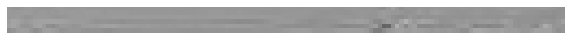

True activity:  standing

Model estimated probs:


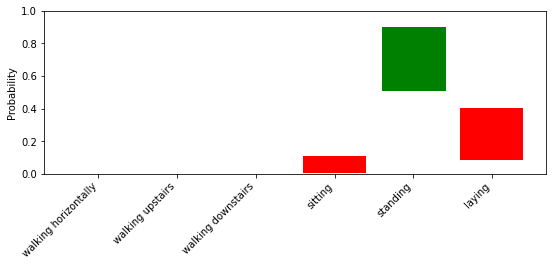

In [50]:
analyze_model_predictions(21)

Accelerometer data:


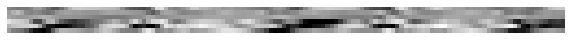

True activity:  walking horizontally

Model estimated probs:


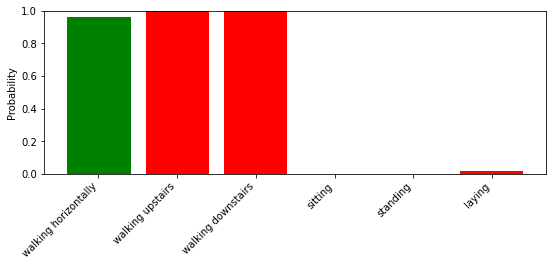

In [57]:
analyze_model_predictions(1137)